# Includes:

In [9]:
%reload_ext autoreload
%autoreload 2
import seaborn as sn
import os
import matplotlib.pyplot as plt

import tf_lite_conversion

from data_paths import get_file_paths_ordered
from pre_process import *
from models import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tensorflow import keras

from IPython.display import Audio

In [2]:
MODEL_NAME = '5speakers'

CSV_DIR = 'csv/'
MODEL_DIR = 'Models/'+ f'{MODEL_NAME}/'
print(MODEL_DIR)
if not os.path.exists(MODEL_DIR):
    print("Creating directory for model : ", MODEL_NAME)
    os.makedirs(MODEL_DIR)

TFLITE_MODEL_NAME = 'tflite_'+ MODEL_NAME
C_MODEL_NAME = MODEL_NAME
print("Model names : ", MODEL_NAME,TFLITE_MODEL_NAME, C_MODEL_NAME)

# Number of speakers and the percentage of the available samples to use to consider:
NB_SPEAKERS = 5
dataset_percentage = 1 # 0.85
print("Number of speakers : ", NB_SPEAKERS)

Models/5speakers/
Creating directory for model :  5speakers
Model names :  5speakers tflite_5speakers 5speakers
Number of speakers :  5


Read data:

In [4]:
paths_train, paths_test, y_train_l, y_test_l, all_paths_l  = get_file_paths_ordered(num_speaker = NB_SPEAKERS, 
                                                                                    test_ratio = 0.2,
                                                                                    balanced_dataset = True)

Total number of speakers in the original dataset: 20
Number of speakers that will be used for training:5 => 25.0%
Original number of files:  3306
Training number of files : 2260 => 68.36055656382335%


In [6]:
slice_len, durations = choose_tot_slice_len(paths=all_paths_l)

segmentLength = 1024

f_s, x_train, y_train, x_test, y_test = get_data_tensors(paths_train=paths_train, paths_test=paths_test, 
                                                         y_train_l=y_train_l, y_test_l=y_test_l,
                                                         tot_slice_len=slice_len,
                                                         used_train_sz_rat=dataset_percentage, 
                                                         used_test_sz_rat=1.,
                                                         segmentLength=segmentLength)

print("Train - test size : ", x_train.shape, x_test.shape)

Visualization of the samples ...


100%|██████████| 566/566 [00:00<00:00, 1802.28it/s]


Train - test size :  (2260, 171, 1024) (566, 171, 1024)


Play a random sample:

In [10]:
i=1
fs_i, audio_data_i = wavfile.read(paths_train[i])
display(Audio(audio_data_i, rate=fs_i))

# Pre-Processing:

In [113]:
#from sklearn.model_selection import train_test_split
#x_train, x_val, y_train, y_val = train_test_split(x_train.numpy(), y_train.numpy(), test_size=0.2)

In [11]:
f_low=80.
f_up=7600.
num_mel_bins=80
num_mfcc=13
segmentLength=1024

x_train_mfcc = compute_mfccs(x_train, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)
x_test_mfcc  = compute_mfccs(x_test, frame_length=segmentLength, sample_rate=f_s, 
                             lower_edge_hertz=f_low, upper_edge_hertz=f_up,
                             num_mel_bins=num_mel_bins, num_mfcc=num_mfcc)

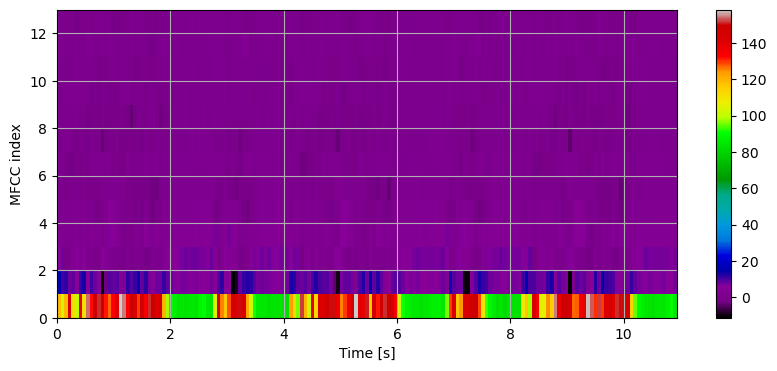

In [12]:
plt.figure(figsize=(10, 4))
extent = [0, x_train_mfcc[i].shape[0]*segmentLength/fs_i, 0, num_mfcc]
plt.imshow(tf.transpose(x_train_mfcc[i], [1, 0, 2]), interpolation="nearest", origin="lower", 
           aspect="auto", extent=extent, cmap='nipy_spectral')
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("MFCC index")
plt.grid()
#plt.savefig(path_figures + 'mfcc_example.png')
plt.show()

# Model:

In [15]:
train_set = x_train_mfcc
test_set = x_test_mfcc

In [16]:
from models import get_model
model_idx = 1
input_shape = train_set.shape
model = get_model(input_shape=input_shape, nb_classes=NB_SPEAKERS, model_idx=model_idx)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (2260, 171, 13, 1)       3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (2260, 171, 13, 16)       160       
                                                                 
 batch_normalization_4 (Batc  (2260, 171, 13, 16)      64        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (2260, 171, 13, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (2260, 86, 7, 32)         4640      
                                                                 
 batch_normalization_5 (Batc  (2260, 86, 7, 32)       

Define learning parameters:

In [18]:
batchSize = 32 #8 # nb of togetherly processed segments(of 1024 samples each) 
epochs = 150 #40 # nb of back propagations
loss_fct = 'sparse_categorical_crossentropy'

Compile the model and Fit the Data:\
@TODO use weights giving the highest accuracy on the validation dataset

In [19]:
model.compile(
    loss=loss_fct, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_keras.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=15, min_lr=1.0e-5,verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),       
]

history_keras = model.fit(x=train_set, 
                          y=y_train, 
                          batch_size=batchSize, 
                          epochs=epochs, 
                          validation_split=0.2,
                          callbacks = callbacks)

Epoch 1/150
57/57 [==============================] - 8s 75ms/step - loss: 0.6149 - accuracy: 0.7832 - val_loss: 1.6552 - val_accuracy: 0.1903 - lr: 0.0010
Epoch 2/150
57/57 [==============================] - 5s 87ms/step - loss: 0.2255 - accuracy: 0.9275 - val_loss: 1.2401 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 3/150
57/57 [==============================] - 5s 81ms/step - loss: 0.1895 - accuracy: 0.9392 - val_loss: 1.4566 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 4/150
57/57 [==============================] - 3s 56ms/step - loss: 0.1453 - accuracy: 0.9524 - val_loss: 3.2811 - val_accuracy: 0.2699 - lr: 0.0010
Epoch 5/150
57/57 [==============================] - 3s 56ms/step - loss: 0.1294 - accuracy: 0.9552 - val_loss: 0.7253 - val_accuracy: 0.6659 - lr: 0.0010
Epoch 6/150
57/57 [==============================] - 3s 54ms/step - loss: 0.0880 - accuracy: 0.9712 - val_loss: 0.7168 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 7/150
57/57 [==============================] - 3s 53ms/step - lo

Evaluate the performance on the test set:

In [20]:
y_pred = model.predict(test_set)

test_loss, test_acc = model.evaluate(test_set,  y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

18/18 [==============================] - 0s 10ms/step
18/18 - 0s - loss: 0.0748 - accuracy: 0.9894 - 220ms/epoch - 12ms/step
Test accuracy: 0.9893993139266968
Test loss: 0.07483447343111038


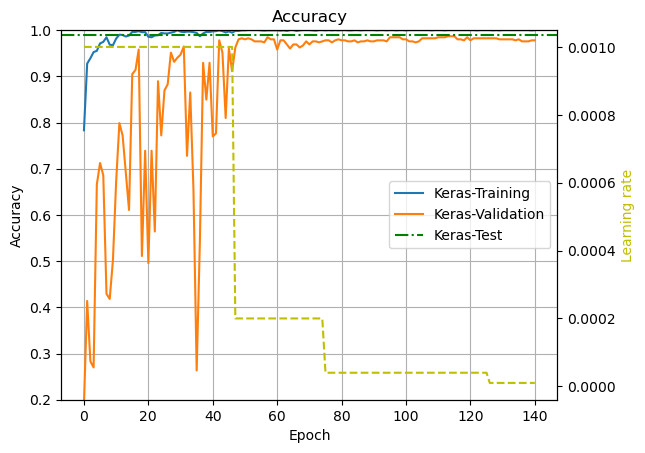

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plt.figure()
ax1.plot(history_keras.history['accuracy'], label='Keras-Training')
ax1.plot(history_keras.history['val_accuracy'], label='Keras-Validation')
ax1.axhline(y=test_acc, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([1/NB_SPEAKERS, 1])
ax2.plot(history_keras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax1.legend(loc='right')
plt.grid()
ax1.grid()
ax2.grid()
plt.title("Accuracy")
#plt.savefig(path_figures + 'keras_acc_epochs.png')
plt.show()

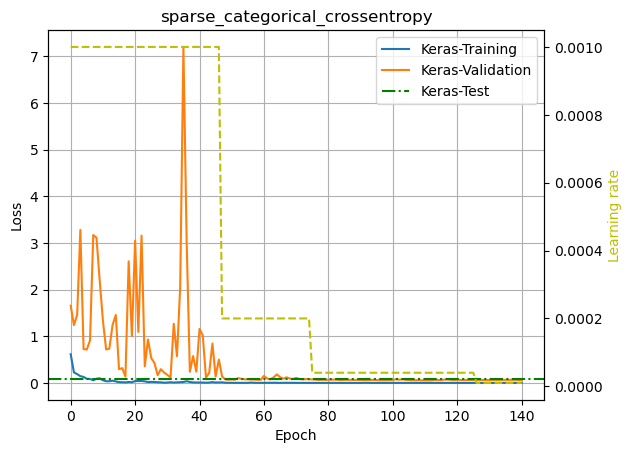

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plt.figure()
ax1.plot(history_keras.history['loss'], label='Keras-Training')
ax1.plot(history_keras.history['val_loss'], label='Keras-Validation')
ax1.axhline(y=test_loss, xmin=0, xmax=epochs, linestyle='-.', color='g', label='Keras-Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax2.plot(history_keras.history['lr'], color='y', linestyle='--')
ax2.set_ylabel('Learning rate', color='y')
ax2.grid()
ax1.legend(loc='upper right')
plt.grid()
plt.title(loss_fct)
#plt.savefig(path_figures + 'keras_loss_epochs.png')
plt.show()

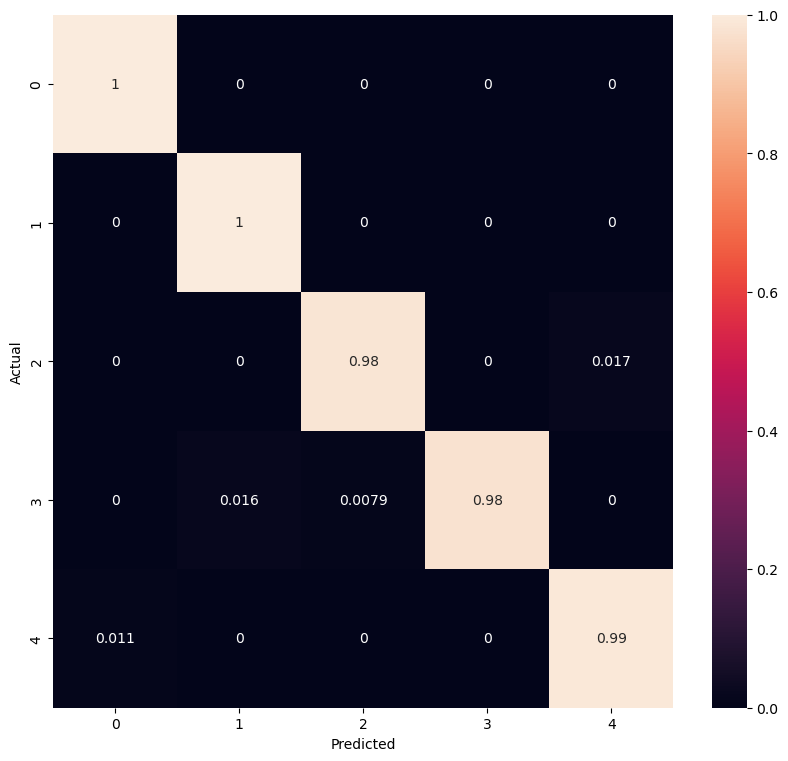

In [24]:
y_pred_hard = np.argmax(y_pred, axis=1)
fig = plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, y_pred_hard, normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(path_figures + 'keras_cm.png')
plt.show()

In [79]:
model.save(MODEL_DIR + MODEL_NAME + '.h5')

In [26]:
model_save_path = MODEL_DIR + MODEL_NAME + '_keras.h5'
h5_in_kb = os.path.getsize(model_save_path) / 1024
print("Keras model file : ", model_save_path)
print("HDF5 Keras Model size: %d KB" % h5_in_kb)

Keras model file :  Models/5speakers/5speakers_keras.h5
HDF5 Keras Model size: 1293 KB


# TF Lite Conversion and Quantization:

In [24]:
from tensorflow.keras.models import load_model
model = load_model(MODEL_DIR + MODEL_NAME + '.h5') 

In [27]:
train_set = x_train_mfcc
train_set.numpy().shape

(2260, 171, 13, 1)

In [29]:
from tf_lite_conversion import convert_to_tf_lite
tflite_model_nq, tflite_model_q, sizes_on_disk, comp_rats, legends = \
    convert_to_tf_lite(keras_model=model,
                       path_keras_model= MODEL_DIR + MODEL_NAME + '_keras.h5', 
                       path_tf_lite_nq_model= MODEL_DIR + TFLITE_MODEL_NAME + '_nq.tflite',
                       train_set=train_set, 
                       path_tf_lite_q_model= MODEL_DIR + TFLITE_MODEL_NAME + '_q.tflite')

INFO:tensorflow:Assets written to: C:\Users\emili\AppData\Local\Temp\tmp_15h6sts\assets


INFO:tensorflow:Assets written to: C:\Users\emili\AppData\Local\Temp\tmp_15h6sts\assets


INFO:tensorflow:Assets written to: C:\Users\emili\AppData\Local\Temp\tmp3ks8dcqi\assets


INFO:tensorflow:Assets written to: C:\Users\emili\AppData\Local\Temp\tmp3ks8dcqi\assets
c:\Users\emili\anaconda3\envs\ml\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


HDF5 Model size without quantization: 1293 KB
TFLite Model size without quantization: 402 KB

Reduction in model size from Keras to TFLite by a factor of 3.217630
Quantized TFLite Model size: 112 KB

Reduction in model size from Keras to TFLiteQuantized by a factor of 11.545638


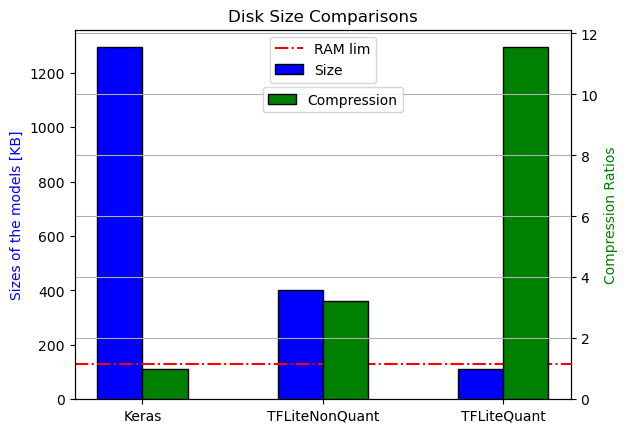

In [31]:
mcu_ram_lim = 128  # KB
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
width=0.25
x_ax_tmp = np.arange(len(legends))

ax1.bar(x_ax_tmp, sizes_on_disk, color='b', width=width, edgecolor='k', label='Size')
ax1.set_ylabel("Sizes of the models [KB]", color='b')
ax1.axhline(y=mcu_ram_lim, xmin=0., xmax=len(legends), linestyle='-.', color='r', label='RAM lim')
ax1.legend(loc='upper center')

ax2.bar(x_ax_tmp+width, comp_rats, color='g', width=width, edgecolor='k', label='Compression')
ax2.set_ylabel("Compression Ratios", color='g')
ax2.legend(loc='center', bbox_to_anchor=(0.52, 0.81))

plt.grid()
plt.title("Disk Size Comparisons")
plt.xticks(x_ax_tmp+width/2, legends)
#plt.savefig(path_figures + 'size_comps.png')
plt.show()

In [33]:
# Show the model size for the non-quantized TFLite model
tflite_quant_in_kb = os.path.getsize(MODEL_DIR + TFLITE_MODEL_NAME + '_q.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (h5_in_kb / tflite_quant_in_kb))

TFLite Model size with 8-bit quantization: 112 KB

Reduction in model size by a factor of 11.545638


# Performance evaluation Non-Quantized Model

In [37]:
from tf_lite_conversion import eval_tf_lite_model
pred_nq = eval_tf_lite_model(path_tf_lite_model = MODEL_DIR + TFLITE_MODEL_NAME + '_nq.tflite',
                             test_set=test_set, 
                             quantized=False)

Evaluated model:  Models/5speakers/tflite_5speakers_nq.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.float32'>
Output shape is [1 5] and of type <class 'numpy.float32'>


In [38]:
tflite_nq_score = accuracy_score(y_test, pred_nq)
print("Accuracy of non-quantized tflite model is {}%".format(tflite_nq_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_nq_score-test_acc)*100))

Accuracy of non-quantized tflite model is 98.93992932862191%
Compared to float32 accuracy of 98.93993139266968%
We have a change of -2.0640477660371914e-06%


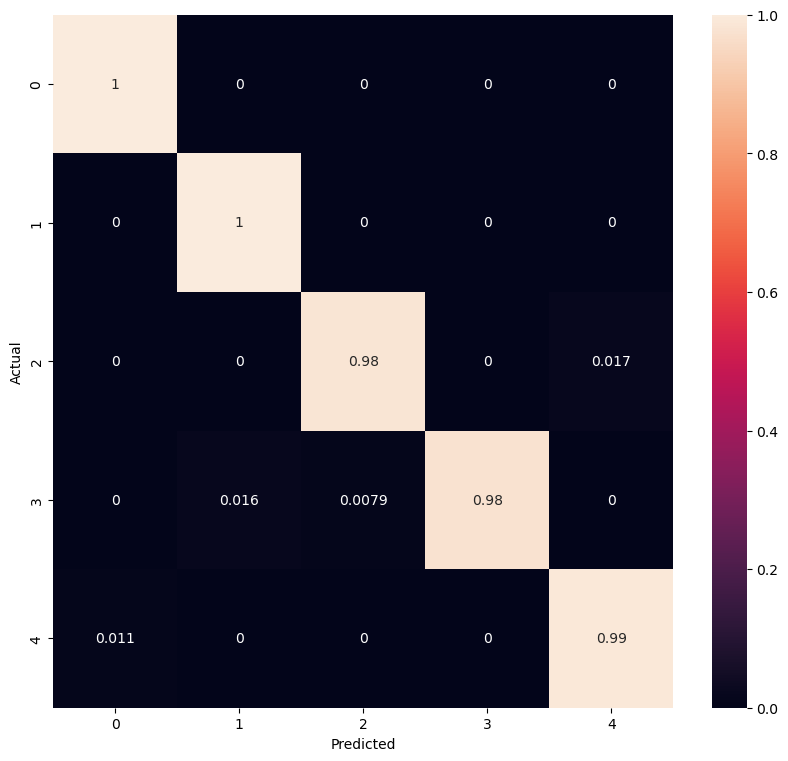

In [40]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_nq, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(path_figures + 'tflite_nq_cm.png')
plt.show()

# Performance evaluation Quantized Model

In [41]:
pred_q = eval_tf_lite_model(path_tf_lite_model = MODEL_DIR + TFLITE_MODEL_NAME + '_q.tflite',
                            quantized=True, 
                            test_set=test_set)

Evaluated model:  Models/5speakers/tflite_5speakers_q.tflite
Input shape is [  1 171  13   1] and of type <class 'numpy.int8'>
Output shape is [1 5] and of type <class 'numpy.int8'>


In [42]:
tflite_q_score = accuracy_score(y_test, pred_q)
print("Accuracy of quantized to int8 model is {}%".format(tflite_q_score*100))
print("Compared to float32 accuracy of {}%".format(test_acc*100))
print("We have a change of {}%".format((tflite_q_score-test_acc)*100))

Accuracy of quantized to int8 model is 96.99646643109541%
Compared to float32 accuracy of 98.93993139266968%
We have a change of -1.9434649615742705%


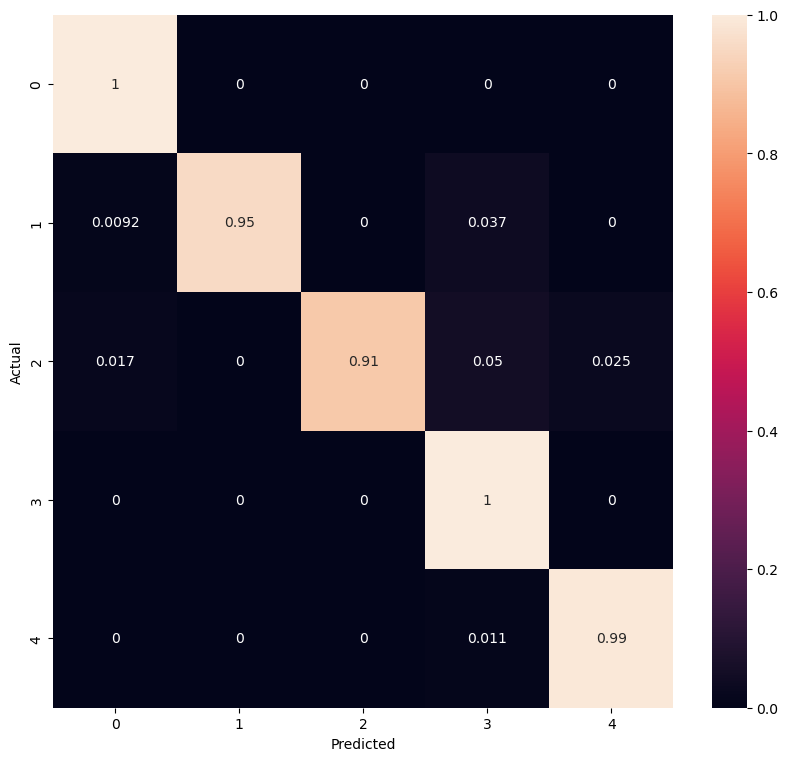

In [44]:
plt.figure(figsize=(10,9))
cm = confusion_matrix(y_test, pred_q, 
                      normalize='true')
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(path_figures + 'tflite_q_cm.png')
plt.show()

# Accuracy comparison

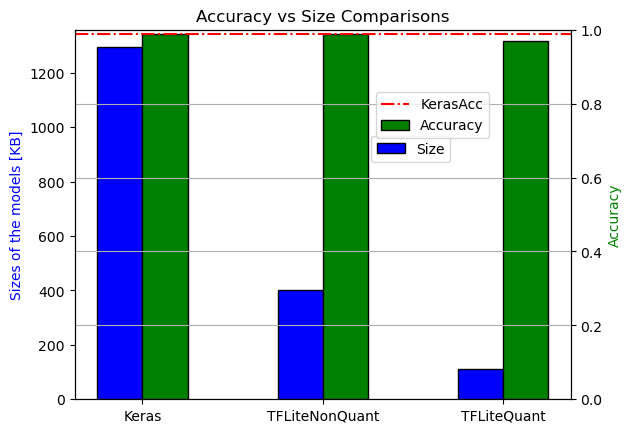

In [45]:
# Plots for comparison
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
width=0.25
x_ax_tmp = np.arange(len(legends))

ax1.bar(x_ax_tmp, sizes_on_disk, color='b', width=width, edgecolor='k', label='Size')
ax1.set_ylabel("Sizes of the models [KB]", color='b')
ax1.legend(loc='upper right',  bbox_to_anchor=(0.77, 0.73))

ax2.bar(x_ax_tmp+width, [test_acc, tflite_nq_score, tflite_q_score], 
        color='g', width=width, edgecolor='k', label='Accuracy')
ax2.set_ylabel("Accuracy", color='g')
ax2.set_ylim([0., 1.])
ax2.axhline(y=test_acc, xmin=0., xmax=1., linestyle='-.', color='r', label='KerasAcc')
ax2.legend(loc='upper right',  bbox_to_anchor=(0.85, 0.85))

plt.grid()
plt.title("Accuracy vs Size Comparisons")
plt.xticks(x_ax_tmp+width/2, legends)
#plt.savefig(path_figures + 'acc_comps.png')
plt.show()